In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import collections

from sklearn.ensemble  import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import time 
import warnings
import os
warnings.filterwarnings("ignore")

In [2]:
data_path = os.path.join('..','..','1_Data','Cleaned Data','data_cleaned.csv')
output_path = 'data'
df = pd.read_csv(data_path)


In [183]:
df = df.sample(1000000)

In [184]:
print(df.head(3))

         Unnamed: 0              Id         groupId         matchId  assists  \
1674654     2031175  2ad1b40d3454b2  69b9eabed4bc8c  736b61d2dc9a75        0   
608744       738975  b25b255f0eafbd  05e127f065cd64  3c79a8391f8253        0   
243921       295603  fac2dde2370424  49ee2fecb19c4a  acf242954fbd7a        0   

         boosts  damageDealt  DBNOs  headshotKills  heals  ...  revives  \
1674654       1        40.13      0              0      1  ...        0   
608744        4       214.60      1              0      2  ...        0   
243921        0        72.75      0              0      1  ...        0   

         rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
1674654         181.5          0           0.0          0                0   
608744         2471.0          0           0.0          0                0   
243921            0.0          0           0.0          0                0   

        walkDistance  weaponsAcquired  winPoints  winPlacePerc  


In [185]:
in_match_player_features = ['assists','boosts','damageDealt','DBNOs','headshotKills',
                           'killPlace','kills','killStreaks','longestKill',
                           'revives','rideDistance','roadKills','roadKills',
                            'swimDistance','teamKills','vehicleDestroys','walkDistance',
                            'weaponsAcquired']

prediction_feature = ['winPlacePerc']

global_player_features = ['killPoints','winPoints','rankPoints']

match_features = ['groupId','matchId','matchDuration']

#### vehicleDestroys, teamKills and roadKills are irrelevant for prediction duo to their distribution (99% with 0 value)

In [186]:
in_match_player_features = [x for x in in_match_player_features if x not in ['roadKills','teamKills','vehicleDestroys']]

In [187]:
in_match_player_features

['assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'killPlace',
 'kills',
 'killStreaks',
 'longestKill',
 'revives',
 'rideDistance',
 'swimDistance',
 'walkDistance',
 'weaponsAcquired']

### Data Correlation

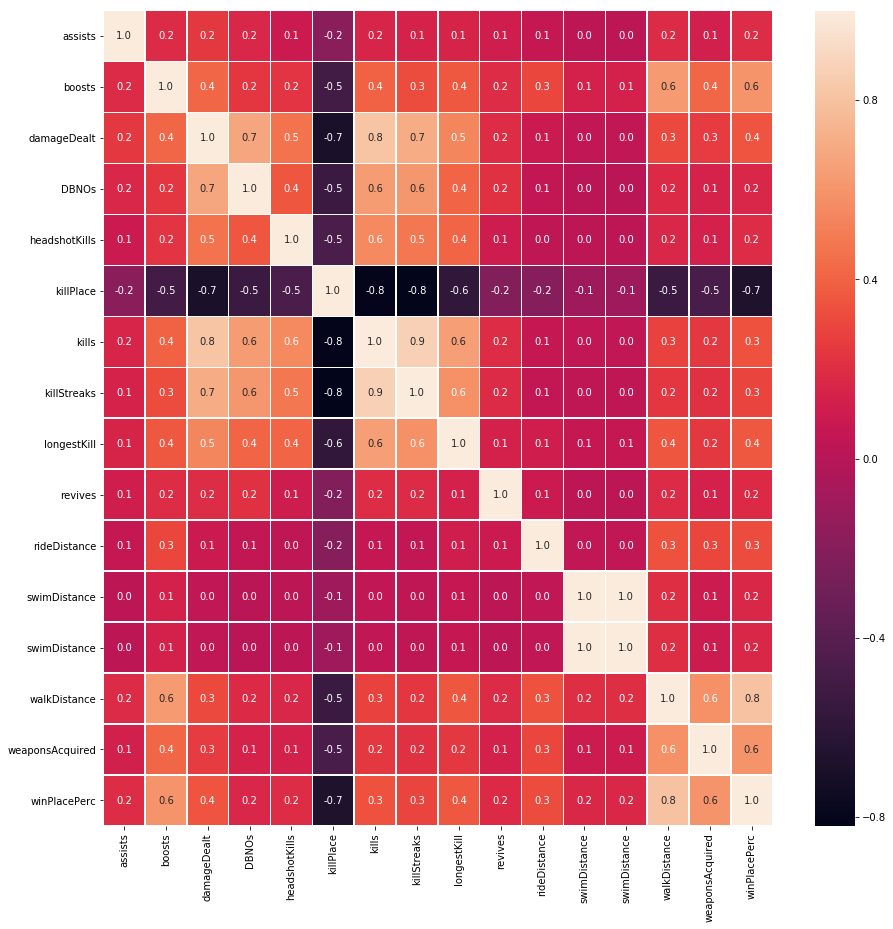

In [31]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df[in_match_player_features+prediction_feature].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

#### Feature of game mode (solo, duo, squad)

In [188]:
df['GameMode'] = np.where(df['numGroups']>50,'Solo',np.where((df['numGroups']>25) & (df['numGroups']<=50),'Duo','Squad'))

In [189]:
df.head(3)

,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,GameMode
1674654,2031175,2ad1b40d3454b2,69b9eabed4bc8c,736b61d2dc9a75,0,1,40.13,0,0,1,...,181.5,0,0.0,0,0,1347.0,3,0,0.6458,Duo
608744,738975,b25b255f0eafbd,05e127f065cd64,3c79a8391f8253,0,4,214.60,1,0,2,...,2471.0,0,0.0,0,0,1534.0,9,1551,0.6444,Duo
243921,295603,fac2dde2370424,49ee2fecb19c4a,acf242954fbd7a,0,0,72.75,0,0,1,...,0.0,0,0.0,0,0,634.8,4,0,0.2069,Duo


In [190]:
new_columns = pd.get_dummies(df[['GameMode']], prefix_sep='_')

In [191]:
new_columns.head(3)

,GameMode_Duo,GameMode_Solo,GameMode_Squad
1674654,1,0,0
608744,1,0,0
243921,1,0,0


In [192]:
df = pd.concat([df,new_columns],axis=1)

In [193]:
df.drop(['GameMode'],inplace=True,axis=1)
df.head(3)

,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,GameMode_Duo,GameMode_Solo,GameMode_Squad
1674654,2031175,2ad1b40d3454b2,69b9eabed4bc8c,736b61d2dc9a75,0,1,40.13,0,0,1,...,0.0,0,0,1347.0,3,0,0.6458,1,0,0
608744,738975,b25b255f0eafbd,05e127f065cd64,3c79a8391f8253,0,4,214.60,1,0,2,...,0.0,0,0,1534.0,9,1551,0.6444,1,0,0
243921,295603,fac2dde2370424,49ee2fecb19c4a,acf242954fbd7a,0,0,72.75,0,0,1,...,0.0,0,0,634.8,4,0,0.2069,1,0,0


In [194]:
general_result_array = {}

#### Linear Regression - no polynomial

In [195]:
kf = KFold(n_splits=10)

X = df[in_match_player_features] 
y = df[prediction_feature]

results_linear = {}

rmse_ = []
r2_ = []

start = time.time()
for k, (train, test) in enumerate(kf.split(X, y)):
    reg = LinearRegression(n_jobs=6)
#     print(X.iloc[train].head(2))
    reg.fit(X.iloc[train], y.iloc[train])
    
    y_pred = reg.predict(X.iloc[test])
    y_true =  y.iloc[test]
    rmse = mean_squared_error(y_true, y_pred)
    r2 = reg.score(X.iloc[test], y.iloc[test])
    rmse_.append(rmse)
    r2_.append(r2)
    
    print("[fold {0}] RMSE {1:.5f} R2: {2:.5f}".
          format(k,rmse,r2))
    
end = time.time()
elapsed_time = (end-start)/60
print('Time spent: {0}'.format(elapsed_time))
general_result_array['linear'] = {'rmse':rmse_,'r2':r2_,'time':elapsed_time}


[fold 0] RMSE 0.01529 R2: 0.81270
[fold 1] RMSE 0.01540 R2: 0.81132
[fold 2] RMSE 0.01542 R2: 0.81022
[fold 3] RMSE 0.01546 R2: 0.81101
[fold 4] RMSE 0.01558 R2: 0.80872
[fold 5] RMSE 0.01533 R2: 0.81159
[fold 6] RMSE 0.01538 R2: 0.81137
[fold 7] RMSE 0.01531 R2: 0.81181
[fold 8] RMSE 0.01534 R2: 0.81229
[fold 9] RMSE 0.01540 R2: 0.81236
Time spent: 0.07441794077555339


#### Linear Regression - polynomial 2

In [196]:
kf = KFold(n_splits=10)

X = df[in_match_player_features] 
y = df[prediction_feature]

r2_ = []
rmse_ = []

start = time.time()
for k, (train, test) in enumerate(kf.split(X, y)):
    reg = make_pipeline(PolynomialFeatures(2), LinearRegression(n_jobs=6))
#     print(X.iloc[train].head(2))
    reg.fit(X.iloc[train], y.iloc[train])
    
    y_pred = reg.predict(X.iloc[test])
    y_true =  y.iloc[test]
    rmse = mean_squared_error(y_true, y_pred)
    r2 = reg.score(X.iloc[test], y.iloc[test])
    
    rmse_.append(rmse)
    r2_.append(r2)
    
    print("[fold {0}] RMSE {1:.5f} R2: {2:.5f}".
          format(k,rmse,r2))
    
end = time.time()
elapsed_time = (end-start)/60
print('Time spent: {0}'.format(elapsed_time))
general_result_array['polinomial'] = {'rmse':rmse_,'r2':r2_,'time':elapsed_time}

[fold 0] RMSE 0.01109 R2: 0.86415
[fold 1] RMSE 0.01110 R2: 0.86397
[fold 2] RMSE 0.01121 R2: 0.86206
[fold 3] RMSE 0.01107 R2: 0.86470
[fold 4] RMSE 0.01117 R2: 0.86286
[fold 5] RMSE 0.01104 R2: 0.86430
[fold 6] RMSE 0.01098 R2: 0.86530
[fold 7] RMSE 0.01099 R2: 0.86491
[fold 8] RMSE 0.01103 R2: 0.86508
[fold 9] RMSE 0.01097 R2: 0.86636
Time spent: 1.8308854738871256


### Neural Networks - 20 neurons at intermediate layer

In [197]:
kf = KFold(n_splits=10)

X = df[in_match_player_features] 
y = df[prediction_feature]

results_pol2 = {}

r2_ = []
rmse_ = []

start = time.time()
for k, (train, test) in enumerate(kf.split(X, y)):
    reg = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(20,)))
    #     print(X.iloc[train].head(2))
    reg.fit(X.iloc[train], y.iloc[train])
    
    y_pred = reg.predict(X.iloc[test])
    y_true =  y.iloc[test]
    rmse = mean_squared_error(y_true, y_pred)
    r2 = reg.score(X.iloc[test], y.iloc[test])
    
    rmse_.append(rmse)
    r2_.append(r2)
    
    print("[fold {0}] RMSE {1:.5f} R2: {2:.5f}".
          format(k,rmse,r2))
    
end = time.time()
elapsed_time = (end-start)/60
print('Time spent: {0}'.format(elapsed_time))
general_result_array['polinomial'] = {'rmse':rmse_,'r2':r2_,'time':elapsed_time}

[fold 0] RMSE 0.00981 R2: 0.87986
[fold 1] RMSE 0.00989 R2: 0.87885
[fold 2] RMSE 0.01029 R2: 0.87333
[fold 3] RMSE 0.01011 R2: 0.87650
[fold 4] RMSE 0.00992 R2: 0.87820
[fold 5] RMSE 0.00982 R2: 0.87924
[fold 6] RMSE 0.00993 R2: 0.87814
[fold 7] RMSE 0.00973 R2: 0.88040
[fold 8] RMSE 0.00995 R2: 0.87821
[fold 9] RMSE 0.00993 R2: 0.87900
Time spent: 2.9142895658810932


### Neural Networks - 10 neurons at intermediate layer

In [198]:
kf = KFold(n_splits=10)

X = df[in_match_player_features] 
y = df[prediction_feature]

r2_ = []
rmse_ = []

start = time.time()
for k, (train, test) in enumerate(kf.split(X, y)):
    reg = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(10,)))
    #     print(X.iloc[train].head(2))
    reg.fit(X.iloc[train], y.iloc[train])
    
    y_pred = reg.predict(X.iloc[test])
    y_true =  y.iloc[test]
    rmse = mean_squared_error(y_true, y_pred)
    r2 = reg.score(X.iloc[test], y.iloc[test])
    
    rmse_.append(rmse)
    r2_.append(r2)
    
    print("[fold {0}] RMSE {1:.5f} R2: {2:.5f}".
          format(k,rmse,r2))
    
end = time.time()
elapsed_time = (end-start)/60
print('Time spent: {0}'.format(elapsed_time))
general_result_array['rnn_10'] = {'rmse':rmse_,'r2':r2_,'time':elapsed_time}

[fold 0] RMSE 0.01046 R2: 0.87195
[fold 1] RMSE 0.01030 R2: 0.87386
[fold 2] RMSE 0.01043 R2: 0.87157
[fold 3] RMSE 0.01033 R2: 0.87369
[fold 4] RMSE 0.01030 R2: 0.87355
[fold 5] RMSE 0.01009 R2: 0.87601
[fold 6] RMSE 0.01001 R2: 0.87716
[fold 7] RMSE 0.00996 R2: 0.87756
[fold 8] RMSE 0.01018 R2: 0.87548
[fold 9] RMSE 0.01043 R2: 0.87295
Time spent: 2.6329830646514893


### Neural Networks - 5 neurons at intermediate layer

In [199]:
kf = KFold(n_splits=10)

X = df[in_match_player_features] 
y = df[prediction_feature]

results_pol2 = {}
r2_ = []
rmse_ = []

start = time.time()
for k, (train, test) in enumerate(kf.split(X, y)):
    reg = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(5,)))
    #     print(X.iloc[train].head(2))
    reg.fit(X.iloc[train], y.iloc[train])
    
    y_pred = reg.predict(X.iloc[test])
    y_true =  y.iloc[test]
    rmse = mean_squared_error(y_true, y_pred)
    r2 = reg.score(X.iloc[test], y.iloc[test])
    
    rmse_.append(rmse)
    r2_.append(r2)
    
    print("[fold {0}] RMSE {1:.5f} R2: {2:.5f}".
          format(k,rmse,r2))
    
end = time.time()
elapsed_time = (end-start)/60    
print('Time spent: {0}'.format(elapsed_time))
general_result_array['rnn_5'] = {'rmse':rmse_,'r2':r2_,'time':elapsed_time}

[fold 0] RMSE 0.01050 R2: 0.87135
[fold 1] RMSE 0.01040 R2: 0.87258
[fold 2] RMSE 0.01073 R2: 0.86796
[fold 3] RMSE 0.01130 R2: 0.86192
[fold 4] RMSE 0.01032 R2: 0.87329
[fold 5] RMSE 0.01087 R2: 0.86633
[fold 6] RMSE 0.01089 R2: 0.86644
[fold 7] RMSE 0.01099 R2: 0.86492
[fold 8] RMSE 0.01105 R2: 0.86478
[fold 9] RMSE 0.01008 R2: 0.87721
Time spent: 2.5974674820899963


### Neural Networks - 2 neurons at intermediate layer

In [200]:
kf = KFold(n_splits=10)

X = df[in_match_player_features] 
y = df[prediction_feature]


r2_ = []
rmse_ = []

start = time.time()
for k, (train, test) in enumerate(kf.split(X, y)):
    reg = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(2,)))
    #     print(X.iloc[train].head(2))
    reg.fit(X.iloc[train], y.iloc[train])
    
    y_pred = reg.predict(X.iloc[test])
    y_true =  y.iloc[test]
    rmse = mean_squared_error(y_true, y_pred)
    r2 = reg.score(X.iloc[test], y.iloc[test])
    
    rmse_.append(rmse)
    r2_.append(r2)
    
    print("[fold {0}] RMSE {1:.5f} R2: {2:.5f}".
          format(k,rmse,r2))
    
end = time.time()
elapsed_time = (end-start)/60
print('Time spent: {0}'.format(elapsed_time))
general_result_array['rnn_2'] = {'rmse':rmse_,'r2':r2_,'time':elapsed_time}

[fold 0] RMSE 0.01176 R2: 0.85599
[fold 1] RMSE 0.01335 R2: 0.83641
[fold 2] RMSE 0.01218 R2: 0.85006
[fold 3] RMSE 0.01347 R2: 0.83534
[fold 4] RMSE 0.01244 R2: 0.84723
[fold 5] RMSE 0.01306 R2: 0.83946
[fold 6] RMSE 0.01332 R2: 0.83654
[fold 7] RMSE 0.01230 R2: 0.84883
[fold 8] RMSE 0.01232 R2: 0.84930
[fold 9] RMSE 0.01209 R2: 0.85272
Time spent: 2.4335683902104694


### Neural Networks - 10-5 structure layer

In [201]:
kf = KFold(n_splits=10)

X = df[in_match_player_features] 
y = df[prediction_feature]


r2_ = []
rmse_ = []

start = time.time()
for k, (train, test) in enumerate(kf.split(X, y)):
    reg = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(10,5,)))
    #     print(X.iloc[train].head(2))
    reg.fit(X.iloc[train], y.iloc[train])
    
    y_pred = reg.predict(X.iloc[test])
    y_true =  y.iloc[test]
    rmse = mean_squared_error(y_true, y_pred)
    r2 = reg.score(X.iloc[test], y.iloc[test])
    
    rmse_.append(rmse)
    r2_.append(r2)
    
    print("[fold {0}] RMSE {1:.5f} R2: {2:.5f}".
          format(k,rmse,r2))
    
end = time.time()
elapsed_time = (end-start)/60
print('Time spent: {0}'.format(elapsed_time))
general_result_array['rnn_10_5'] = {'rmse':rmse_,'r2':r2_,'time':elapsed_time}

[fold 0] RMSE 0.00985 R2: 0.87934
[fold 1] RMSE 0.00995 R2: 0.87814
[fold 2] RMSE 0.01011 R2: 0.87556
[fold 3] RMSE 0.01010 R2: 0.87660
[fold 4] RMSE 0.00989 R2: 0.87857
[fold 5] RMSE 0.01034 R2: 0.87285
[fold 6] RMSE 0.00990 R2: 0.87855
[fold 7] RMSE 0.00998 R2: 0.87727
[fold 8] RMSE 0.00989 R2: 0.87893
[fold 9] RMSE 0.00974 R2: 0.88136
Time spent: 3.709914708137512


### Neural Networks - 20-5 structure layer

In [202]:
kf = KFold(n_splits=10)

X = df[in_match_player_features] 
y = df[prediction_feature]

results_pol2 = {}
r2_ = []
rmse_ = []

start = time.time()
for k, (train, test) in enumerate(kf.split(X, y)):
    reg = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(20,5,)))
    #     print(X.iloc[train].head(2))
    reg.fit(X.iloc[train], y.iloc[train])
    
    y_pred = reg.predict(X.iloc[test])
    y_true =  y.iloc[test]
    rmse = mean_squared_error(y_true, y_pred)
    r2 = reg.score(X.iloc[test], y.iloc[test])
    
    rmse_.append(rmse)
    r2_.append(r2)
    
    print("[fold {0}] RMSE {1:.5f} R2: {2:.5f}".
          format(k,rmse,r2))
end = time.time()
elapsed_time = (end-start)/60   
print('Time spent: {0}'.format(elapsed_time))
general_result_array['rnn_20_5'] = {'rmse':rmse_,'r2':r2_,'time':elapsed_time}

[fold 0] RMSE 0.00982 R2: 0.87975
[fold 1] RMSE 0.00979 R2: 0.88004
[fold 2] RMSE 0.00986 R2: 0.87858
[fold 3] RMSE 0.00987 R2: 0.87941
[fold 4] RMSE 0.00991 R2: 0.87827
[fold 5] RMSE 0.00964 R2: 0.88147
[fold 6] RMSE 0.01004 R2: 0.87687
[fold 7] RMSE 0.00963 R2: 0.88163
[fold 8] RMSE 0.00981 R2: 0.88000
[fold 9] RMSE 0.00962 R2: 0.88275
Time spent: 3.89723531405131


### GradientBoosting - 100 arvores

In [203]:
kf = KFold(n_splits=10)

X = df[in_match_player_features] 
y = df[prediction_feature]

r2_ = []
rmse_ = []

start = time.time()
for k, (train, test) in enumerate(kf.split(X, y)):
    reg = make_pipeline(GradientBoostingRegressor(n_estimators=100))
    #     print(X.iloc[train].head(2))
    reg.fit(X.iloc[train], y.iloc[train])
    
    y_pred = reg.predict(X.iloc[test])
    y_true =  y.iloc[test]
    rmse = mean_squared_error(y_true, y_pred)
    r2 = reg.score(X.iloc[test], y.iloc[test])
    
    rmse_.append(rmse)
    r2_.append(r2)
    
    print("[fold {0}] RMSE {1:.5f} R2: {2:.5f}".
          format(k,rmse,r2))
end = time.time()
elapsed_time = (end-start)/60
print('Time spent: {0}'.format(elapsed_time))
general_result_array['gradientboosting'] = {'rmse':rmse_,'r2':r2_,'time':elapsed_time}

[fold 0] RMSE 0.01040 R2: 0.87268
[fold 1] RMSE 0.01045 R2: 0.87199
[fold 2] RMSE 0.01059 R2: 0.86969
[fold 3] RMSE 0.01066 R2: 0.86970
[fold 4] RMSE 0.01053 R2: 0.87063
[fold 5] RMSE 0.01046 R2: 0.87138
[fold 6] RMSE 0.01038 R2: 0.87262
[fold 7] RMSE 0.01042 R2: 0.87194
[fold 8] RMSE 0.01046 R2: 0.87198
[fold 9] RMSE 0.01036 R2: 0.87375
Time spent: 12.70135991970698


### XGBoost - 100 arvores

In [204]:
kf = KFold(n_splits=10)

X = df[in_match_player_features] 
y = df[prediction_feature]

r2_ = []
rmse_ = []

start = time.time()
for k, (train, test) in enumerate(kf.split(X, y)):
    reg = xgb.XGBRegressor(n_estimators=100)
    #     print(X.iloc[train].head(2))
    reg.fit(X.iloc[train], y.iloc[train])
    
    y_pred = reg.predict(X.iloc[test])
    y_true =  y.iloc[test]
    rmse = mean_squared_error(y_true, y_pred)
    r2 = reg.score(X.iloc[test], y.iloc[test])
    
    rmse_.append(rmse)
    r2_.append(r2)
    
    print("[fold {0}] RMSE {1:.5f} R2: {2:.5f}".
          format(k,rmse,r2))
end = time.time()
elapsed_time = (end-start)/60  
print('Time spent: {0}'.format(elapsed_time))
general_result_array['xgboost'] = {'rmse':rmse_,'r2':r2_,'time':elapsed_time}

[fold 0] RMSE 0.01036 R2: 0.87309
[fold 1] RMSE 0.01045 R2: 0.87199
[fold 2] RMSE 0.01059 R2: 0.86968
[fold 3] RMSE 0.01066 R2: 0.86970
[fold 4] RMSE 0.01053 R2: 0.87063
[fold 5] RMSE 0.01046 R2: 0.87143
[fold 6] RMSE 0.01038 R2: 0.87262
[fold 7] RMSE 0.01042 R2: 0.87194
[fold 8] RMSE 0.01046 R2: 0.87202
[fold 9] RMSE 0.01036 R2: 0.87375
Time spent: 8.680144516626994


### Results

In [108]:
keys_rmse = {}
# rmse_ = []
keys_r2 = {}
for key,value in general_result_array.items():
    keys_rmse[key] = np.array(general_result_array[key]['rmse']).mean()
    keys_r2[key] = np.array(general_result_array[key]['r2']).mean()

In [157]:
keys_r2 = collections.OrderedDict(sorted(keys_r2.items(), key=lambda x: x[1]))
keys_rmse_ordered_by_r2 = {}

for key in keys_r2:
    new_key = key.replace('rnn','r_nn_')
    keys_rmse_ordered_by_r2[new_key] = keys_rmse[key]
    

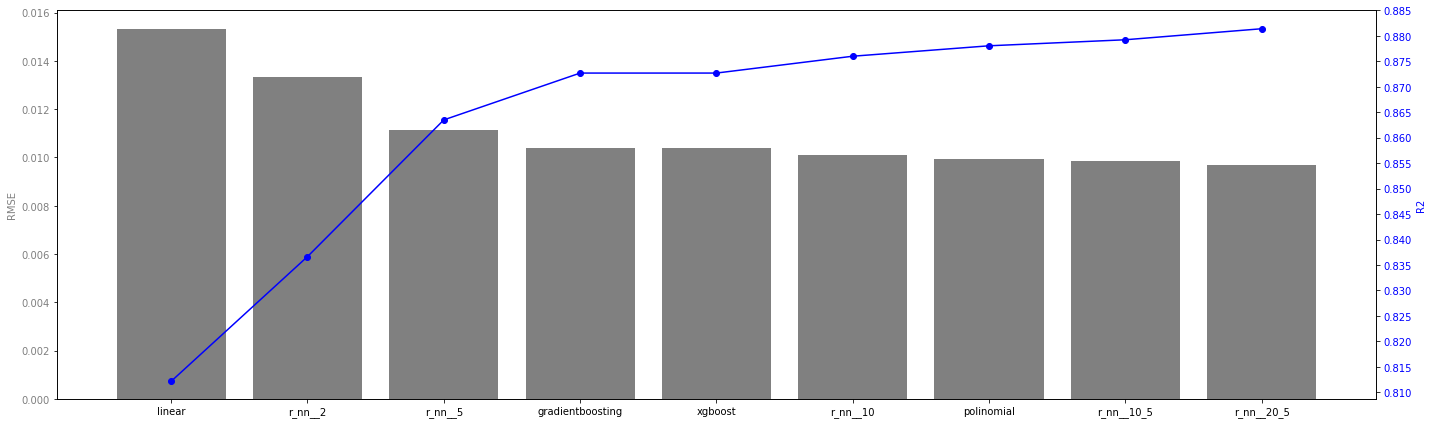

<Figure size 432x288 with 0 Axes>

In [178]:
fig, ax1 = plt.subplots(figsize=(20, 6))


names = list(keys_rmse_ordered_by_r2.keys())
values = list(keys_rmse_ordered_by_r2.values())
values2 = list(keys_r2.values())


# plt.show()

color = 'grey'
ax1.set_ylabel('RMSE', color=color)
ax1.bar(range(len(names)),values,tick_label=names,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('R2', color=color)  # we already handled the x-label with ax1
ax2.plot(names, values2, 'bo-',color=color)
# ax2.scatter(names, values2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.yticks(np.arange(0.81, 0.89, 0.005))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.savefig(os.path.join('out','resultado_benchmark.png'))

In [207]:
import json

output_path = os.path.join('out','general_result_array.json')
with open(output_path, 'w') as outfile:
    json.dump(general_result_array, outfile)